In [79]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.scale import LogScale
import json
from utils import dref_dataframe

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind6")

def parse_logs(path: Path, iter: int = 1) -> pd.DataFrame:
    datas = []
    for i in range(iter):
        data = pd.read_csv(path / f"out_{i}.csv")
        meta = json.load((path / f"meta.json").open())
        data["iter"] = i
        data["shrink"] = (data["shrink"] / 1e9) / meta["args"]["mem"]
        data["grow"] = (data["grow"] / 1e9) / meta["args"]["mem"]
        datas.append(data)
    data = pd.concat(datas)
    match path.stem.split("-", 1)[1].replace("-manual", "").replace("-movable", ""):
        case "base": mode = "virtio-balloon"
        case "huge": mode = "virtio-balloon-huge"
        case "llfree": mode = "llfree-balloon"
        case "llfree-vfio": mode = "llfree-balloon-vfio"
        case "huge": mode = "virtio-huge"
        case m: mode = m
    data["mode"] = mode
    return pd.DataFrame(data)


     shrink      grow  iter                 mode
0  0.645577  0.358269     0       virtio-balloon
0  0.862461  0.359838     1       virtio-balloon
0  0.893249  0.359224     2       virtio-balloon
0  0.005615  0.002561     0  virtio-balloon-huge
0  0.005532  0.002562     1  virtio-balloon-huge
0  0.005587  0.002556     2  virtio-balloon-huge
0  0.031927  0.007833     0           virtio-mem
0  0.022926  0.007672     1           virtio-mem
0  0.023061  0.007884     2           virtio-mem
0  0.043735  0.173478     0      virtio-mem-vfio
0  0.035502  0.174238     1      virtio-mem-vfio
0  0.035728  0.174518     2      virtio-mem-vfio
0  0.002343  0.000102     0       llfree-balloon
0  0.002624  0.000102     1       llfree-balloon
0  0.002636  0.000103     2       llfree-balloon
0  0.014959  0.000102     0  llfree-balloon-vfio
0  0.015356  0.000104     1  llfree-balloon-vfio
0  0.014917  0.000102     2  llfree-balloon-vfio


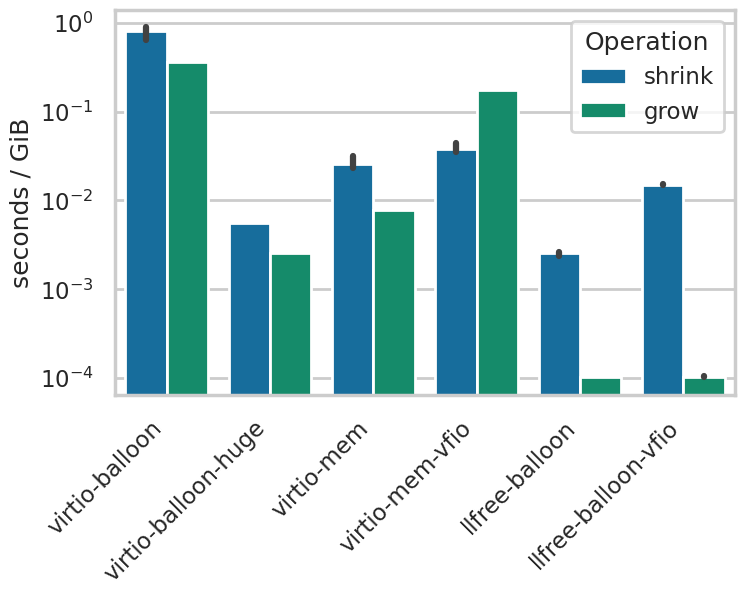

In [86]:
paths = [
    Path("inflate/latest-base-manual"),
    Path("inflate/latest-huge-manual"),
    Path("inflate/latest-virtio-mem-movable"),
    Path("inflate/latest-virtio-mem-movable-vfio"),
    Path("inflate/latest-llfree-manual"),
    Path("inflate/latest-llfree-manual-vfio"),
]
data = pd.concat([parse_logs(p, 3) for p in paths])
print(data)

plt.figure(figsize=(8, 5))
pgd = data.melt(id_vars=["mode", "iter"], value_vars=["shrink", "grow"],
                var_name="op", value_name="time")
p = sns.barplot(pgd, y="time", x="mode", hue="op")
p.legend(title="Operation")
p.set_yscale("log")
p.set_ylabel("seconds / GiB")
p.set_xlabel(None)
_ = p.set_xticklabels(p.get_xticklabels(), rotation=45, ha="right")

     shrink      grow  iter                 mode
0  0.645577  0.358269     0       virtio-balloon
0  0.862461  0.359838     1       virtio-balloon
0  0.893249  0.359224     2       virtio-balloon
0  0.005615  0.002561     0  virtio-balloon-huge
0  0.005532  0.002562     1  virtio-balloon-huge
0  0.005587  0.002556     2  virtio-balloon-huge
0  0.031927  0.007833     0           virtio-mem
0  0.022926  0.007672     1           virtio-mem
0  0.023061  0.007884     2           virtio-mem
0  0.043735  0.173478     0      virtio-mem-vfio
0  0.035502  0.174238     1      virtio-mem-vfio
0  0.035728  0.174518     2      virtio-mem-vfio
0  0.002343  0.000102     0       llfree-balloon
0  0.002624  0.000102     1       llfree-balloon
0  0.002636  0.000103     2       llfree-balloon
0  0.014959  0.000102     0  llfree-balloon-vfio
0  0.015356  0.000104     1  llfree-balloon-vfio
0  0.014917  0.000102     2  llfree-balloon-vfio
9803.050586804482


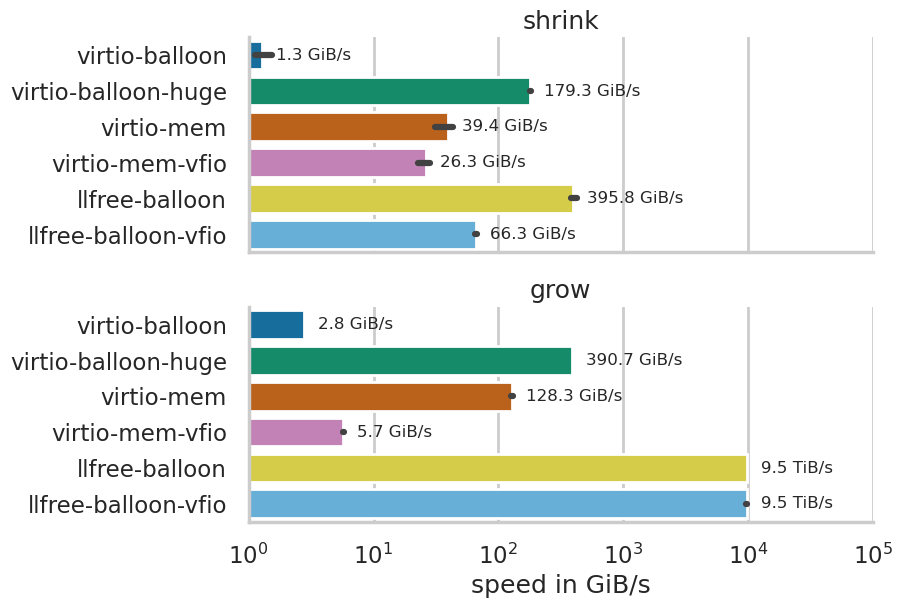

In [85]:
paths = [
    Path("inflate/latest-base-manual"),
    Path("inflate/latest-huge-manual"),
    Path("inflate/latest-virtio-mem-movable"),
    Path("inflate/latest-virtio-mem-movable-vfio"),
    Path("inflate/latest-llfree-manual"),
    Path("inflate/latest-llfree-manual-vfio"),
]

data = pd.concat([parse_logs(p, 3) for p in paths])
print(data)

pgd = data.melt(id_vars=["mode", "iter"], value_vars=["shrink", "grow"],
                var_name="op", value_name="time")
pgd["time"] = 1 / pgd["time"]
print(pgd["time"].max())
p = sns.catplot(pgd, kind="bar", y="mode", hue="mode", x="time", row="op", legend=False, aspect=3, height=3.2)
p.set(xlabel="speed in GiB/s")
p.set(ylabel=None)
p.set(xlim=(1, 1e5))

def mem_fmt(x: float) -> str:
    x *= 1024**3
    sizes = ["TiB", "GiB", "MiB", "KiB"]
    for i, suffix in enumerate(sizes):
        mul = 1024 ** (len(sizes) - i)
        if x > mul: return f"{x/mul:.1f} {suffix}/s"
    return f"{x:.2} B/s"

for ax in p.axes_dict.values():
    ax.set_xscale("log", base=10)
    for c in ax.containers:
        ax.bar_label(c, fmt=mem_fmt, fontsize=12, padding=10)
p.set_titles(row_template="{row_name}")
p.figure.savefig("inflate/inflate.pdf", bbox_inches="tight")
dref_dataframe("inflate", Path("inflate"), ["mode", "iter", "op"], pgd)